# Plotting profiles together with bathymetry

In [5]:
import ctd
import gsw
from ctd.read import _basename
import gsw
import requests
import os
import re
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cmo
from scipy.interpolate import griddata

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Provide URL to load a single file that has already been downloaded to OOI's OPENDAP server
# remember to use #fillmismatch
# Create directory that includes all urls
data_url = {}
data_url['inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132326640Z-CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191006T150003-20191031T212239.977728.nc#fillmismatch'
data_url['central_inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132900316Z-CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191007T210003-20191031T212442.986087.nc#fillmismatch'
data_url['central_offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133142674Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191031T212529.983845.nc#fillmismatch'
data_url['offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133343088Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191013T160003-20191031T211622.990750.nc#fillmismatch'


In [8]:
# Load the data file using xarray
def load2xarray(location):
    """
    Load data at given location and reduce to variables of interest.
    """
    ds = xr.open_dataset(data_url[location])
    ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
    print('Dataset '+ location +' has %d points' % ds.time.size)
    ds = ds[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity']]
    return ds

profiles={}
for loc in list(data_url.keys()):
    profiles[loc] = load2xarray(loc)


Dataset inshore has 158237 points
Dataset central_inshore has 210513 points
Dataset central_offshore has 236989 points
Dataset offshore has 199587 points


In [10]:
# profiles['inshore'].practical_salinity
#     for cast in profiles:
#         names = [df._metadata.get("name") for df in profiles]
#         lons, lats, data = [], [], []
#         lons.append(cast._metadata.get("lon"))
#         lats.append(cast._metadata.get("lat"))
#         data.append(cast[var])



Steps I need to take:
1) Plot a downcast of each profiler


In [13]:
def plot_section(profiles, var, reverse=False, **kw):
    lons, lats, data = [], [], []
    for profile in profiles:
        lons.append(profile._metadata.get("lon"))
        lats.append(profiles._metadata.get("lat"))
        data.append(cast[var])


    sec = pd.concat(data, axis=1)
    sec.columns = names

    z = sec.index.values
    h = get_maxdepth(sec)

    lons, lats = map(np.atleast_2d, (lons, lats))
    x = np.append(0, np.cumsum(distance(lons, lats)[0] / 1e3))
    z = sec.index.values.astype(float)
    data = ma.masked_invalid(sec)

    if reverse:
        lons = lons[::-1]
        lats = lats[::-1]
        data = data.T[::-1].T
        h = h[::-1]

    # Contour key words.
    extend = kw.pop("extend", "both")
    fontsize = kw.pop("fontsize", 12)
    labelsize = kw.pop("labelsize", 11)
    cmap = kw.pop("cmap", None)
    levels = kw.pop(
        "levels", np.arange(np.floor(np.nanmin(data)), np.ceil(np.nanmax(data)) + 0.5, 0.5),
    )

    # Colorbar key words.
    pad = kw.pop("pad", 0.04)
    aspect = kw.pop("aspect", 40)
    shrink = kw.pop("shrink", 0.9)
    fraction = kw.pop("fraction", 0.05)

    # Topography mask key words.
    dx = kw.pop("dx", 1.0)
    kind = kw.pop("kind", "linear")
    linewidth = kw.pop("linewidth", 1.5)

    # Station symbols key words.
    station_marker = kw.pop("station_marker", None)
    color = kw.pop("color", "k")
    offset = kw.pop("offset", -5)
    alpha = kw.pop("alpha", 0.5)

    # Figure.
    figsize = kw.pop("figsize", (12, 6))
    fig, ax = plt.subplots(figsize=figsize)
    xm, hm = gen_topomask(h, lons, lats, dx=dx, kind=kind)
    ax.plot(xm, hm, color="black", linewidth=linewidth, zorder=3)
    ax.fill_between(xm, hm, y2=hm.max(), color="0.9", zorder=3)

    if station_marker:
        ax.plot(
            x,
            [offset] * len(h),
            color=color,
            marker=station_marker,
            alpha=alpha,
            zorder=5,
        )
    ax.set_xlabel("Cross-shore distance [km]", fontsize=fontsize)
    ax.set_ylabel("Depth [m]", fontsize=fontsize)
    ax.set_ylim(offset, hm.max())
    ax.invert_yaxis()

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.xaxis.set_tick_params(tickdir="out", labelsize=labelsize, pad=1)
    ax.yaxis.set_tick_params(tickdir="out", labelsize=labelsize, pad=1)

    cs = ax.contourf(
        x, z, data, cmap=cmap, levels=levels, alpha=1.0, extend=extend, zorder=2,
    )

    cb = fig.colorbar(
        mappable=cs,
        ax=ax,
        orientation="vertical",
        aspect=aspect,
        shrink=shrink,
        fraction=fraction,
        pad=pad,
    )
    return fig, ax, cb


# fig, ax, cb = plot_section(c)

In [15]:
#Extract a single time for a single day and plot all side by side
I_URL = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132326640Z-CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191006T150003-20191031T212239.977728.nc#fillmismatch'
CI_URL = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132900316Z-CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191007T210003-20191031T212442.986087.nc#fillmismatch'
CO_URL = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133142674Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191031T212529.983845.nc#fillmismatch'
O_URL = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133343088Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191013T160003-20191031T211622.990750.nc#fillmismatch'

In [19]:
ids = xr.open_dataset(I_URL)
cids = xr.open_dataset(CI_URL)
cods = xr.open_dataset(CO_URL)
ods = xr.open_dataset(O_URL)

In [20]:
ids = ids.swap_dims({'obs': 'time'}) #Swap dimensions
cids = cids.swap_dims({'obs': 'time'}) #Swap dimensions
cods = cods.swap_dims({'obs': 'time'}) #Swap dimensions
ods = ods.swap_dims({'obs': 'time'}) #Swap dimensions

In [21]:
# select same day for each profiler
datesel='2019-10-15T03'
ids15=ids.sel(time=datesel, method="nearest")
cids15=cids.sel(time=datesel, method="nearest")
cods15=cods.sel(time=datesel, method="nearest")
ods15=ods.sel(time=datesel, method="nearest")

ids15

<xarray.Dataset>
Dimensions:                                          (time: 801)
Coordinates:
    obs                                              (time) int32 51980 ... 5...
    lon                                              (time) float64 ...
    pressure                                         (time) float64 ...
    lat                                              (time) float64 ...
  * time                                             (time) datetime64[ns] 20...
Data variables:
    practical_salinity                               (time) float64 ...
    ctdpf_ckl_seawater_temperature_qartod_executed   |S64 ...
    driver_timestamp                                 (time) datetime64[ns] ...
    id                                               (time) |S64 ...
    conductivity                                     (time) float64 ...
    temperature                                      (time) float64 ...
    density                                          (time) float64 ...
    ctdpf_ckl_seawater_pressure                      (time) float64 ...
    internal_timestamp                               (time) datetime64[ns] ...
    ctdpf_ckl_seawater_conductivity_qartod_results   (time) float32 ...
    ctdpf_ckl_seawater_temperature_qartod_results    (time) float32 ...
    ctdpf_ckl_seawater_temperature                   (time) float64 ...
    ingestion_timestamp                              (time) datetime64[ns] ...
    port_timestamp                                   (time) datetime64[ns] ...
    ctdpf_ckl_seawater_conductivity_qartod_executed  |S64 ...
    deployment                                       (time) int32 ...
    preferred_timestamp                              (time) object ...
    ctdpf_ckl_seawater_conductivity                  (time) float64 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    node:                            WFP01
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               recovered_wfp
    stream:                          ctdpf_ckl_wfp_instrument_recovered
    featureType:                     point
    creator_email:                   
    publisher_name:                  Ocean Observatories Initiative
    date_modified:                   2020-08-06T13:23:41.238357
    keywords:                        
    cdm_data_type:                   Point
    references:                      More information can be found at http://...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    date_created:                    2020-08-06T13:23:41.238351
    id:                              CP03ISPM-WFP01-03-CTDPFK000-recovered_wf...
    requestUUID:                     607b59bd-cfc8-4659-868c-a894a197fb41
    contributor_role:                
    summary:                         Dataset Generated by Stream Engine from ...
    keywords_vocabulary:             
    institution:                     Ocean Observatories Initiative
    naming_authority:                org.oceanobservatories
    feature_Type:                    point
    infoUrl:                         http://oceanobservatories.org/
    license:                         
    contributor_name:                
    uuid:                            607b59bd-cfc8-4659-868c-a894a197fb41
    creator_name:                    Ocean Observatories Initiative
    title:                           Data produced by Stream Engine version 1...
    sensor:                          03-CTDPFK000
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    acknowledgement:                 
    Conventions:                     CF-1.6
    project:                         Ocean Observatories Initiative
    source:                          CP03ISPM-WFP01-03-CTDPFK000-recovered_wf...
    publisher_url:                   http://oceanobservatories.org/
    creator_url:       

## Bathymetry

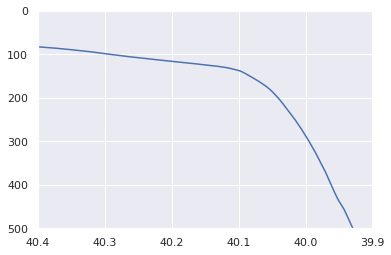

In [30]:
#Load in bathymetric data
bathymetry=xr.open_dataset('data/GMRT_39-41N_70-71W.nc')

#Plot
z=bathymetry.z.values.reshape([1023,535]).mean(axis=1)

#Get y range
x=np.linspace(bathymetry.x_range[0],bathymetry.x_range[1],535) # Longitude
y=np.linspace(bathymetry.y_range[1],bathymetry.y_range[0],1023) #Latitude OOI North to South
#gsw.p_from_z()

#PLot bathymetry 
plt.plot(y,-z)
plt.xlim(40.4, 39.9) # lims inshore and offshore stations
plt.ylim(500,0); #maximum depth offshore ~451m

## Practical salinity profiles

(500.0, 0.0)

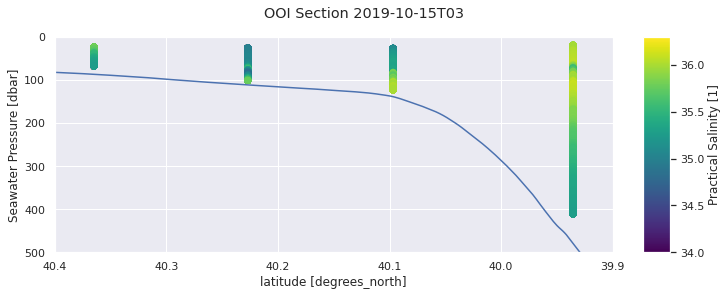

In [61]:
# Plot spatial section: practical salinity 
fig,ax = plt.subplots(ncols=1,figsize=(10,4),sharey=True,constrained_layout=True)

cci=ids15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="practical_salinity", ax=ax, 
                       add_guide=True, vmin=34, vmax=36.3)
ccci=cids15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="practical_salinity", ax=ax,
                       add_guide=False, vmin=34, vmax=36.3)
ccco=cods15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="practical_salinity", ax=ax,
                       add_guide=False, vmin=34, vmax=36.3)
cco=ods15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="practical_salinity", ax=ax,
                       add_guide=False, vmin=34, vmax=36.3)

fig.suptitle(f"OOI Section {datesel}")

#PLot bathymetry 
plt.plot(y,-z)
plt.xlim(40.4, 39.9) # lims inshore and offshore stations
plt.ylim(500, 0) #maximum depth offshore ~451m

## Temperature Profiles

(500.0, 0.0)

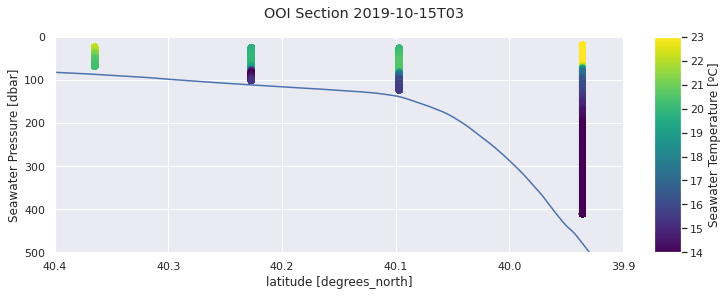

In [56]:
# Plot spatial section: temperature 
fig,ax = plt.subplots(ncols=1,figsize=(10,4),sharey=True,constrained_layout=True)

cci=ids15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="ctdpf_ckl_seawater_temperature", ax=ax, 
                       add_guide=True, vmin=14,vmax=23)
ccci=cids15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="ctdpf_ckl_seawater_temperature", ax=ax,
                       add_guide=False, vmin=14,vmax=23)
ccco=cods15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="ctdpf_ckl_seawater_temperature", ax=ax,
                       add_guide=False, vmin=14,vmax=23)
cco=ods15.plot.scatter(x="lat", y="ctdpf_ckl_seawater_pressure",
                       hue="ctdpf_ckl_seawater_temperature", ax=ax,
                       add_guide=False, vmin=14,vmax=23)

fig.suptitle(f"OOI Section {datesel}")

#PLot bathymetry 
plt.plot(y,-z)
plt.xlim(40.4, 39.9) # lims inshore and offshore stations
plt.ylim(500, 0) #maximum depth offshore ~451m

In [26]:
# Spatial Interpolation 
# Plot spatial section: practical salinity using cmocean
# Using scipy.interpolate has a function griddata which is the same as matlab basically. 
#It uses numpy array as input and the numpy package has the meshgrid command 
#[X,Y]= meshgrid(-109.445:-0.0001:-109.47,(0:1:350)');
#% [X,Y]= meshgrid(-78:-0.05:-79,(0:1:300)');
#n2 = griddata(d,Ps,N,X,Y, 'cubic');
#ee = griddata(d,Ps,E,X,Y, 'cubic');
#pcolor(X,-Y,real(n2)), shading interp, colormap(h,odv),caxis([-9 -1]),


#matrix
SAL=np.array([])

xx = np.arange(39.9,40.41,0.01)
zz = np.arange(0,500,1)
xv, yv = np.meshgrid(xx,zz)

#array with salinity data 4 stations
#SAL = array()

#grid_sal = griddata(z,  xv,yv,method='linear')



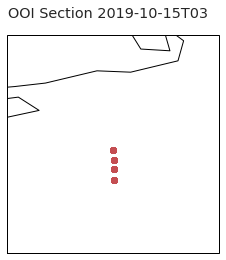

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


lons=np.array([ids15.lon,cids15.lon,cods15.lon,ods15.lon])
lats=np.array([ids15.lat,cids15.lat,cods15.lat,ods15.lat])
dx = dy = 1.5
bbox = -70.90-dx, -70.88+dx, 40.4-dy, 40.5+dy
# https://ocefpaf.github.io/python4oceanographers/blog/2013/07/29/python-ctd/
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={"projection": projection})
ax.set_extent(bbox)
ax.coastlines()

#c1=ids15.plot.scatter(x="lon", y="lat",color='red',marker='o')
#c2=cids15.plot.scatter(x="lon", y="lat",color='red',marker='o') 
#c3=cods15.plot.scatter(x="lon", y="lat",color='red',marker='o') 
#c4=ods15.plot.scatter(x="lon", y="lat",color='red',marker='o') 
plt.plot(ids15.lon,ids15.lat,'ro')
plt.plot(cids15.lon,cids15.lat,'ro')
plt.plot(cods15.lon,cods15.lat,'ro')
plt.plot(ods15.lon,ods15.lat,'ro')

#plt.text((ids15.lon)-0.5,(ids15.lat)-0.5,'IN',
#        horizontalalignment='right',transform=ccrs.Geodetic())


fig.suptitle(f"OOI Section {datesel}")
plt.show()